# 📊 Listening History Analysis

This notebook analyzes your **Spotify data exports** to understand your actual listening patterns and how they differ from your library.

**Prerequisites:** 
- Run `01_sync_data.ipynb` to download your library
- Run `02_analyze_library.ipynb` for library insights
- Run `03_playlist_analysis.ipynb` for playlist analysis

**Data Sources:**
1. **Spotify Account Data/** - Basic streaming history, search queries, library, Wrapped data
2. **Spotify Extended Streaming History/** - Detailed streaming history with metadata
3. **Spotify Technical Log Information/** - Technical logs and playback events

**What This Notebook Does:**
- 📊 Analyzes actual listening patterns vs. library/playlists
- 🔍 Discovers search patterns and music discovery
- ⏰ Identifies temporal listening habits
- 🎵 Finds favorite tracks/artists from actual plays
- 💡 Provides insights for playlist automation and redundancy detection

**Next Steps:**
- `05_liked_songs_monthly_playlists.ipynb` - Create playlists based on listening data
- `06_identify_redundant_playlists.ipynb` - Enhanced redundancy detection with listening patterns


In [1]:
# Add project to path
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✅ Project root: {PROJECT_ROOT}")


✅ Project root: /Users/aryamaan/Desktop/Projects/spotim8


In [2]:
# Install dependencies
%pip install -q pandas matplotlib seaborn pyarrow tqdm


Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('dark_background')
sns.set_palette("husl")

# Data directories
ACCOUNT_DATA_DIR = PROJECT_ROOT / "Spotify Account Data"
EXTENDED_HISTORY_DIR = PROJECT_ROOT / "Spotify Extended Streaming History"
TECHNICAL_LOGS_DIR = PROJECT_ROOT / "Spotify Technical Log Information"
DATA_DIR = PROJECT_ROOT / "data"

print("📁 Data directories:")
print(f"   • Account Data: {ACCOUNT_DATA_DIR}")
print(f"   • Extended History: {EXTENDED_HISTORY_DIR}")
print(f"   • Technical Logs: {TECHNICAL_LOGS_DIR}")
print(f"   • Project Data: {DATA_DIR}")


📁 Data directories:
   • Account Data: /Users/aryamaan/Desktop/Projects/spotim8/Spotify Account Data
   • Extended History: /Users/aryamaan/Desktop/Projects/spotim8/Spotify Extended Streaming History
   • Technical Logs: /Users/aryamaan/Desktop/Projects/spotim8/Spotify Technical Log Information
   • Project Data: /Users/aryamaan/Desktop/Projects/src/data


## 1️⃣ Data Loading Functions


In [4]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_basic_streaming_history():
    """Load basic streaming history from Account Data folder."""
    files = list(ACCOUNT_DATA_DIR.glob("StreamingHistory_music_*.json"))
    all_streams = []
    
    for f in sorted(files):
        print(f"📥 Loading {f.name}...")
        with open(f, 'r', encoding='utf-8') as fp:
            data = json.load(fp)
            all_streams.extend(data)
    
    if not all_streams:
        return None
    
    df = pd.DataFrame(all_streams)
    
    # Parse datetime
    df['endTime'] = pd.to_datetime(df['endTime'], format='%Y-%m-%d %H:%M')
    df['date'] = df['endTime'].dt.date
    df['hour'] = df['endTime'].dt.hour
    df['day_of_week'] = df['endTime'].dt.day_name()
    df['day_of_week_num'] = df['endTime'].dt.dayofweek
    df['month'] = df['endTime'].dt.to_period('M')
    df['minutes_played'] = df['msPlayed'] / 60000
    
    # Filter out very short plays (likely skips) - at least 30 seconds
    df = df[df['msPlayed'] >= 30000]
    
    return df

def load_extended_streaming_history():
    """Load extended streaming history with detailed metadata."""
    files = list(EXTENDED_HISTORY_DIR.glob("Streaming_History_Audio_*.json"))
    all_streams = []
    
    for f in sorted(files):
        print(f"📥 Loading {f.name}...")
        with open(f, 'r', encoding='utf-8') as fp:
            data = json.load(fp)
            all_streams.extend(data)
    
    if not all_streams:
        return None
    
    df = pd.DataFrame(all_streams)
    
    # Parse timestamp
    df['ts'] = pd.to_datetime(df['ts'])
    df['date'] = df['ts'].dt.date
    df['hour'] = df['ts'].dt.hour
    df['day_of_week'] = df['ts'].dt.day_name()
    df['day_of_week_num'] = df['ts'].dt.dayofweek
    df['month'] = df['ts'].dt.to_period('M')
    df['minutes_played'] = df['ms_played'] / 60000
    
    # Filter meaningful plays
    df = df[df['ms_played'] >= 30000]  # At least 30 seconds
    df = df[~df['skipped']]  # Not skipped
    
    return df

def load_search_queries():
    """Load search query history."""
    search_file = ACCOUNT_DATA_DIR / "SearchQueries.json"
    if not search_file.exists():
        return None
    
    with open(search_file, 'r', encoding='utf-8') as fp:
        data = json.load(fp)
    
    df = pd.DataFrame(data)
    
    # Handle datetime format: "2025-10-04T22:39:02.044Z[UTC]" - strip [UTC] part
    if 'searchTime' in df.columns:
        # Remove [UTC] suffix if present, then parse ISO8601 format
        df['searchTime'] = df['searchTime'].astype(str).str.replace(r'\[UTC\]$', '', regex=True)
        df['searchTime'] = pd.to_datetime(df['searchTime'], utc=True, errors='coerce')
        df['date'] = df['searchTime'].dt.date
        df['hour'] = df['searchTime'].dt.hour
        df['month'] = df['searchTime'].dt.to_period('M')
    
    return df

def load_wrapped_data():
    """Load Spotify Wrapped 2024 summary."""
    wrapped_file = ACCOUNT_DATA_DIR / "Wrapped2024.json"
    if not wrapped_file.exists():
        return None
    
    with open(wrapped_file, 'r', encoding='utf-8') as fp:
        data = json.load(fp)
    
    return data

def load_your_library():
    """Load saved tracks library."""
    library_file = ACCOUNT_DATA_DIR / "YourLibrary.json"
    if not library_file.exists():
        return None
    
    with open(library_file, 'r', encoding='utf-8') as fp:
        data = json.load(fp)
    
    if 'tracks' in data:
        df = pd.DataFrame(data['tracks'])
        return df
    return None

print("✅ Data loading functions defined")


✅ Data loading functions defined


In [5]:
# Load all available data
print("="*70)
print("LOADING DATA")
print("="*70)

basic_history = load_basic_streaming_history()
extended_history = load_extended_streaming_history()
search_queries = load_search_queries()
wrapped_data = load_wrapped_data()
your_library = load_your_library()

# Use extended history if available, otherwise basic
history = extended_history if extended_history is not None else basic_history

# Determine which columns to use
if extended_history is not None:
    artist_col = 'master_metadata_album_artist_name'
    track_col = 'master_metadata_track_name'
    time_col = 'ts'
else:
    artist_col = 'artistName'
    track_col = 'trackName'
    time_col = 'endTime'

print("\n✅ Data loaded:")
if history is not None:
    print(f"   • Streaming History: {len(history):,} records")
    print(f"   • Date range: {history[time_col].min()} to {history[time_col].max()}")
    print(f"   • Total listening: {history['minutes_played'].sum() / 60:.1f} hours")
if search_queries is not None:
    print(f"   • Search Queries: {len(search_queries):,} searches")
if wrapped_data:
    print(f"   • Wrapped 2024: Loaded")
if your_library is not None:
    print(f"   • Your Library: {len(your_library):,} saved tracks")


LOADING DATA
📥 Loading StreamingHistory_music_0.json...
📥 Loading StreamingHistory_music_1.json...
📥 Loading Streaming_History_Audio_2021-2022_0.json...
📥 Loading Streaming_History_Audio_2022-2023_1.json...
📥 Loading Streaming_History_Audio_2023-2025_3.json...
📥 Loading Streaming_History_Audio_2023_2.json...
📥 Loading Streaming_History_Audio_2025_4.json...

✅ Data loaded:
   • Streaming History: 46,383 records
   • Date range: 2021-09-06 23:27:14+00:00 to 2025-12-25 23:15:27+00:00
   • Total listening: 2375.3 hours
   • Search Queries: 763 searches
   • Wrapped 2024: Loaded
   • Your Library: 5,168 saved tracks


## 3️⃣ Listening Patterns Analysis


In [6]:
if history is not None:
    # Top Artists by Total Play Time
    top_artists_time = history.groupby(artist_col)['minutes_played'].sum().sort_values(ascending=False).head(20)
    
    # Top Artists by Play Count
    top_artists_count = history.groupby(artist_col).size().sort_values(ascending=False).head(20)
    
    # Top Tracks by Play Count
    top_tracks = history.groupby([artist_col, track_col]).size().sort_values(ascending=False).head(20)
    
    print("🎤 TOP 20 ARTISTS BY LISTENING TIME:")
    for i, (artist, minutes) in enumerate(top_artists_time.items(), 1):
        hours = minutes / 60
        print(f"   {i:2d}. {artist:40} {hours:>6.1f} hours")
    
    print("\n🎵 TOP 20 TRACKS BY PLAY COUNT:")
    for i, ((artist, track), count) in enumerate(top_tracks.items(), 1):
        print(f"   {i:2d}. {artist} - {track[:50]}")
        print(f"       {count} plays")
else:
    print("⚠️  No streaming history available")


🎤 TOP 20 ARTISTS BY LISTENING TIME:
    1. Travis Scott                               82.4 hours
    2. Metro Boomin                               67.7 hours
    3. Drake                                      53.8 hours
    4. Mac Miller                                 38.0 hours
    5. J. Cole                                    35.0 hours
    6. Baby Keem                                  28.3 hours
    7. The Weeknd                                 24.7 hours
    8. A$AP Rocky                                 24.4 hours
    9. Hotel Ugly                                 23.6 hours
   10. Don Toliver                                22.6 hours
   11. Kendrick Lamar                             22.3 hours
   12. Steve Lacy                                 21.6 hours
   13. Tyler, The Creator                         20.9 hours
   14. Masego                                     20.4 hours
   15. GoldLink                                   20.1 hours
   16. Aaron May                                 

## 4️⃣ Integration Ideas for Playlist Automation

### 🎯 How Streaming History Can Enhance Playlist Automation


In [7]:
if history is not None:
    print("="*70)
    print("INTEGRATION IDEAS FOR PLAYLIST AUTOMATION")
    print("="*70)
    
    print("""
    💡 IDEA 1: "Most Played" Monthly Playlists
    --------------------------------------------
    Current: Monthly playlists based on Liked Songs added that month
    Enhancement: Create "Top Played" playlists based on actual listening
    
    Implementation:
    - Analyze streaming history for each month
    - Rank tracks by play count or total listening time
    - Create playlists like "AJTopDec25" (top 25 most played in December)
    - Can be integrated into scripts/sync.py alongside existing monthly playlists
    
    Benefits:
    - Reflects actual listening habits, not just what you saved
    - Identifies "comfort tracks" you listen to repeatedly
    - Discovers tracks you love but forgot to like
    """)
    
    # Example: Most played tracks by month
    print("\n📊 Example: Most Played Tracks by Month (last 3 months):")
    recent_months = sorted(history['month'].unique())[-3:]
    for month in recent_months:
        month_data = history[history['month'] == month]
        top_tracks_month = month_data.groupby([artist_col, track_col]).size().sort_values(ascending=False).head(5)
        print(f"\n   {month}:")
        for (artist, track), count in top_tracks_month.items():
            print(f"      • {artist} - {track[:40]}: {count} plays")
    
    print("""
    💡 IDEA 2: "Discovery Playlists" - Searched but Not Saved
    ---------------------------------------------------------
    Enhancement: Track what you search for but don't save
    
    Implementation:
    - Cross-reference search queries with saved tracks
    - Identify searches that led to plays but no save
    - Create monthly "Discovery" playlists with these tracks
    
    Benefits:
    - Capture music you're exploring but not ready to commit to
    - Identify discovery patterns
    - Help you remember tracks you wanted to check out later
    """)
    
    print("""
    💡 IDEA 3: "Time-Based Playlists" - Morning, Evening, Weekend
    -------------------------------------------------------------
    Enhancement: Create playlists based on when you actually listen
    
    Implementation:
    - Analyze listening patterns by hour/day of week
    - Identify peak listening times and genres during those times
    - Auto-generate playlists like "Morning Vibes", "Evening Chill", "Weekend Energy"
    
    Benefits:
    - Playlists that match your actual listening schedule
    - Better music discovery aligned with your routine
    """)
    
    # Example: Listening by time of day
    if 'hour' in history.columns:
        hourly_genres = history.groupby('hour')[artist_col].apply(lambda x: x.value_counts().head(3).index.tolist())
        print("\n📊 Example: Top Artists by Hour of Day:")
        for hour in [6, 9, 12, 18, 21]:
            if hour in hourly_genres.index:
                artists = hourly_genres[hour]
                print(f"   {hour:02d}:00 - {', '.join(artists[:3])}")
    
    print("""
    💡 IDEA 4: "Repeat Listeners" - Comfort Zone Playlist
    ------------------------------------------------------
    Enhancement: Identify tracks you listen to repeatedly
    
    Implementation:
    - Find tracks with high play frequency (e.g., played 5+ times in a month)
    - Create "Comfort Zone" or "On Repeat" playlists
    - Update monthly with new repeat tracks
    
    Benefits:
    - Capture your current obsessions
    - Create playlists of tracks you can't get enough of
    """)
    
    # Example: Repeat listeners
    track_play_counts = history.groupby([artist_col, track_col]).size()
    repeat_tracks = track_play_counts[track_play_counts >= 5].sort_values(ascending=False).head(10)
    print("\n📊 Example: Top Repeat Tracks (5+ plays):")
    for (artist, track), count in repeat_tracks.items():
        print(f"   • {artist} - {track[:40]}: {count} plays")
    
    print("""
    💡 IDEA 5: "Forgotten Favorites" - In Library But Never Played
    ----------------------------------------------------------------
    Enhancement: Identify tracks in your library that you never actually listen to
    
    Implementation:
    - Compare library tracks with streaming history
    - Find tracks saved but never played (or played < 2 times)
    - Optionally create a "Cleanup" playlist or suggest removal
    
    Benefits:
    - Library cleanup suggestions
    - Identify what you thought you'd like vs. what you actually like
    - Free up space in playlists
    """)
    
    print("""
    💡 IDEA 6: "Skip Rate Analysis" - Improve Playlist Quality
    -----------------------------------------------------------
    Enhancement: Use skip data to improve playlist curation
    
    Implementation (requires extended history):
    - Track skip rates for tracks in auto-generated playlists
    - Identify tracks with high skip rates
    - Optionally remove frequently skipped tracks from playlists
    - Learn which genres/artists you skip most
    
    Benefits:
    - Higher quality playlists with better track selection
    - Data-driven playlist improvement
    """)
    
    if extended_history is not None and 'skipped' in extended_history.columns:
        skip_rate = extended_history['skipped'].sum() / len(extended_history) * 100
        print(f"\n📊 Current Skip Rate: {skip_rate:.1f}%")
        if skip_rate > 20:
            print("   ⚠️  High skip rate - playlist quality could be improved")


INTEGRATION IDEAS FOR PLAYLIST AUTOMATION

    💡 IDEA 1: "Most Played" Monthly Playlists
    --------------------------------------------
    Current: Monthly playlists based on Liked Songs added that month
    Enhancement: Create "Top Played" playlists based on actual listening
    
    Implementation:
    - Analyze streaming history for each month
    - Rank tracks by play count or total listening time
    - Create playlists like "AJTopDec25" (top 25 most played in December)
    - Can be integrated into scripts/sync.py alongside existing monthly playlists
    
    Benefits:
    - Reflects actual listening habits, not just what you saved
    - Identifies "comfort tracks" you listen to repeatedly
    - Discovers tracks you love but forgot to like
    

📊 Example: Most Played Tracks by Month (last 3 months):

   2025-10:
      • Feed Your Soul - 852 Hz Block Your Brain From Overthinkin: 26 plays
      • Feed Your Soul - 852 Hz Quiet Your Brain: 23 plays
      • Feed Your Soul - 852 Hz C

## 5️⃣ Integration Ideas for Redundant Playlist Finder

### 🗑️ How Streaming History Can Enhance Redundancy Detection


In [8]:
print("="*70)
print("INTEGRATION IDEAS FOR REDUNDANT PLAYLIST FINDER")
print("="*70)

print("""
💡 IDEA 1: "Listening-Based Similarity" - Beyond Track Overlap
----------------------------------------------------------------
Current: Compares playlists based on track overlap (Jaccard similarity)
Enhancement: Also consider actual listening patterns

Implementation:
- For each playlist, calculate listening frequency of its tracks
- Compare playlists not just by shared tracks, but by shared listening patterns
- Two playlists might have different tracks but serve the same listening purpose
- Example: "Workout 2024" and "Gym Mix" might have different tracks but same listening context

Benefits:
- Find functionally redundant playlists even if track overlap is low
- Identify playlists that serve the same purpose in your listening routine
""")

print("""
💡 IDEA 2: "Playlist Usage Analysis" - Which Playlists Do You Actually Use?
---------------------------------------------------------------------------
Enhancement: Identify playlists you never actually play from

Implementation:
- Track which playlists tracks are played from (if available in extended history)
- Or: Compare playlist tracks with actual listening history
- Identify playlists where <10% of tracks have been played
- Mark these as candidates for deletion/consolidation

Benefits:
- Remove "dead" playlists you created but never use
- Focus redundancy analysis on actively used playlists
- Clean up library more effectively
""")

if history is not None:
    # Example: Check if we can identify unused tracks
    print("\n📊 Example Analysis:")
    print("   We can identify tracks in playlists that are never played")
    print("   This helps identify 'dead' playlists with unused tracks")

print("""
💡 IDEA 3: "Temporal Redundancy" - Playlists for Same Time Periods
-------------------------------------------------------------------
Enhancement: Find playlists that serve the same temporal purpose

Implementation:
- Analyze when tracks from each playlist are typically played
- Group playlists by listening time patterns (morning, evening, weekend, etc.)
- Identify playlists with similar temporal usage patterns
- Suggest merging playlists that serve the same time-based purpose

Benefits:
- Consolidate playlists that serve the same listening context
- Better organization by actual usage, not just track similarity
""")

if history is not None and 'hour' in history.columns:
    print("\n📊 Example: Temporal Patterns by Playlist (if we had playlist context):")
    print("   We could group playlists by when their tracks are typically played")

print("""
💡 IDEA 4: "Genre-Based Redundancy with Listening Data"
------------------------------------------------------
Enhancement: Use actual listening to refine genre-based redundancy detection

Implementation:
- Current system uses genre classification from artist metadata
- Enhancement: Also consider what genres you actually listen to most
- Two playlists might be genre-similar but serve different purposes
- Use listening frequency to weight genre similarity

Benefits:
- More accurate redundancy detection
- Considers not just what's in playlists, but how you use them
""")

print("""
💡 IDEA 5: "Playlist Consolidation Suggestions Based on Listening"
------------------------------------------------------------------
Enhancement: Suggest consolidations based on actual listening patterns

Implementation:
- Identify playlists with similar listening patterns (same artists, same times, etc.)
- Even if track overlap is low, suggest consolidation if listening patterns match
- Create "smart merge" suggestions that consider both tracks and usage

Benefits:
- More intelligent consolidation recommendations
- Better playlist organization based on actual behavior
""")

print("""
💡 IDEA 6: "Redundancy Score with Listening Weight"
----------------------------------------------------
Enhancement: Weight redundancy scores by actual listening frequency

Implementation:
- Current: Jaccard similarity based on track presence
- Enhancement: Weight by how often tracks are actually played
- Playlists with shared tracks that are frequently played = higher redundancy
- Playlists with shared tracks that are rarely played = lower redundancy

Benefits:
- More accurate redundancy detection
- Focus on playlists you actually use
""")


INTEGRATION IDEAS FOR REDUNDANT PLAYLIST FINDER

💡 IDEA 1: "Listening-Based Similarity" - Beyond Track Overlap
----------------------------------------------------------------
Current: Compares playlists based on track overlap (Jaccard similarity)
Enhancement: Also consider actual listening patterns

Implementation:
- For each playlist, calculate listening frequency of its tracks
- Compare playlists not just by shared tracks, but by shared listening patterns
- Two playlists might have different tracks but serve the same listening purpose
- Example: "Workout 2024" and "Gym Mix" might have different tracks but same listening context

Benefits:
- Find functionally redundant playlists even if track overlap is low
- Identify playlists that serve the same purpose in your listening routine


💡 IDEA 2: "Playlist Usage Analysis" - Which Playlists Do You Actually Use?
---------------------------------------------------------------------------
Enhancement: Identify playlists you never actually pl

In [ ]:
print("="*70)
print("CODE EXAMPLES FOR IMPLEMENTATION")
print("="*70)

print("""
Example 1: Most Played Monthly Playlist Generator
-------------------------------------------------
This could be added to scripts/sync.py or as a new function:

```python
def create_most_played_monthly_playlists(history_df, sp, owner_name="AJ", top_n=25):
    \"\"\"Create monthly playlists based on actual listening data.\"\"\"
    from datetime import datetime
    
    current_month = datetime.now().strftime("%Y-%m")
    
    # Get current month's listening data
    month_data = history_df[history_df['month'] == current_month]
    
    # Count plays per track
    track_plays = month_data.groupby([artist_col, track_col]).size().reset_index(name='plays')
    track_plays = track_plays.sort_values('plays', ascending=False).head(top_n)
    
    # Get track URIs (would need to search Spotify API)
    track_uris = []
    for _, row in track_plays.iterrows():
        # Search for track and get URI
        results = sp.search(q=f"artist:{row[artist_col]} track:{row[track_col]}", type='track', limit=1)
        if results['tracks']['items']:
            track_uris.append(results['tracks']['items'][0]['uri'])
    
    # Create playlist
    playlist_name = f"{owner_name}Top{current_month[-2:]}{current_month[:2]}"
    playlist = sp.user_playlist_create(
        sp.current_user()['id'],
        playlist_name,
        public=False,
        description=f"Top {top_n} most played tracks in {current_month}"
    )
    
    # Add tracks
    if track_uris:
        sp.playlist_add_items(playlist['id'], track_uris)
    
    return playlist
```
""")

print("""
Example 2: Enhanced Redundancy Detection with Listening Data
------------------------------------------------------------
This could be added to notebooks/06_identify_redundant_playlists.ipynb:

```python
def listening_weighted_similarity(playlist1_tracks, playlist2_tracks, listening_history):
    \"\"\"Calculate similarity weighted by actual listening frequency.\"\"\"
    # Get shared tracks
    shared = playlist1_tracks & playlist2_tracks
    
    if not shared:
        return 0.0
    
    # Get listening counts for shared tracks
    shared_listens = listening_history[
        listening_history['track_id'].isin(shared)
    ].groupby('track_id').size()
    
    # Weight similarity by listening frequency
    total_listens = shared_listens.sum()
    max_possible = len(shared) * listening_history.groupby('track_id').size().max()
    
    return total_listens / max_possible if max_possible > 0 else 0.0

def find_functionally_redundant_playlists(playlists, playlist_tracks, listening_history):
    \"\"\"Find playlists that serve the same function based on listening patterns.\"\"\"
    redundant = []
    
    for i, (pid1, tracks1) in enumerate(playlist_tracks.items()):
        for j, (pid2, tracks2) in enumerate(playlist_tracks.items()):
            if i >= j:
                continue
            
            # Calculate traditional similarity
            jaccard = jaccard_similarity(tracks1, tracks2)
            
            # Calculate listening-weighted similarity
            listening_sim = listening_weighted_similarity(tracks1, tracks2, listening_history)
            
            # If either similarity is high, mark as redundant
            if jaccard > 0.8 or listening_sim > 0.7:
                redundant.append((pid1, pid2, jaccard, listening_sim))
    
    return redundant
```
""")

print("""
Example 3: Discovery Playlist Generator
-----------------------------------------
Create playlists from searches that led to plays but no saves:

```python
def create_discovery_playlist(search_queries, listening_history, saved_tracks, sp):
    \"\"\"Create playlist from tracks discovered via search but not saved.\"\"\"
    # Get tracks that were searched for and played
    searched_tracks = set()
    for query in search_queries['searchQuery'].unique():
        # Find tracks played after this search (simplified - would need time correlation)
        # This is a simplified example
        pass
    
    # Find tracks that were played but not saved
    played_tracks = set(listening_history['track_id'].unique())
    saved_track_ids = set(saved_tracks['uri'].str.replace('spotify:track:', ''))
    
    discovery_tracks = played_tracks - saved_track_ids
    
    # Create playlist
    playlist = sp.user_playlist_create(
        sp.current_user()['id'],
        "Discovery - Not Saved",
        public=False,
        description="Tracks discovered but not yet saved to library"
    )
    
    # Add tracks (would need to convert to URIs)
    # sp.playlist_add_items(playlist['id'], track_uris)
    
    return playlist
```
""")


CODE EXAMPLES FOR IMPLEMENTATION

Example 1: Most Played Monthly Playlist Generator
-------------------------------------------------
This could be added to scripts/sync.py or as a new function:

```python
def create_most_played_monthly_playlists(history_df, sp, owner_name="AJ", top_n=25):
    """Create monthly playlists based on actual listening data."""
    from datetime import datetime
    
    current_month = datetime.now().strftime("%Y-%m")
    
    # Get current month's listening data
    month_data = history_df[history_df['month'] == current_month]
    
    # Count plays per track
    track_plays = month_data.groupby([artist_col, track_col]).size().reset_index(name='plays')
    track_plays = track_plays.sort_values('plays', ascending=False).head(top_n)
    
    # Get track URIs (would need to search Spotify API)
    track_uris = []
    for _, row in track_plays.iterrows():
        # Search for track and get URI
        results = sp.search(q=f"artist:{row[artist_col]} track:{row[

## 7️⃣ Detailed Analysis: Listening vs Library


In [ ]:
# Compare listening behavior with library
try:
    from spotim8.analysis import LibraryAnalyzer
    
    analyzer = LibraryAnalyzer(DATA_DIR).load()
    library_tracks = analyzer.tracks
    library_artists = analyzer.artists
    
    print("="*70)
    print("LISTENING vs LIBRARY COMPARISON")
    print("="*70)
    
    if history is not None:
        # Get unique tracks/artists from listening
        if extended_history is not None:
            listened_tracks = set(zip(
                extended_history['master_metadata_track_name'].str.lower().fillna(''),
                extended_history['master_metadata_album_artist_name'].str.lower().fillna('')
            ))
        else:
            listened_tracks = set(zip(
                basic_history['trackName'].str.lower().fillna(''),
                basic_history['artistName'].str.lower().fillna('')
            ))
        
        # Get library tracks
        library_track_artists = library_tracks.merge(
            analyzer.track_artists[analyzer.track_artists['position'] == 0],
            on='track_id'
        ).merge(analyzer.artists[['artist_id', 'name']], on='artist_id')
        
        library_track_set = set(zip(
            library_track_artists['name_x'].str.lower().fillna(''),
            library_track_artists['name_y'].str.lower().fillna('')
        ))
        
        # Analysis
        not_in_library = listened_tracks - library_track_set
        in_library_not_played = library_track_set - listened_tracks
        
        print(f"\n📊 Comparison Statistics:")
        print(f"   • Unique tracks listened: {len(listened_tracks):,}")
        print(f"   • Tracks in library: {len(library_track_set):,}")
        print(f"   • Listened but not saved: {len(not_in_library):,}")
        print(f"   • Saved but never played: {len(in_library_not_played):,}")
        
        if len(not_in_library) > 0:
            discovery_rate = len(not_in_library) / len(listened_tracks) * 100
            print(f"   • Discovery rate: {discovery_rate:.1f}%")
        
        if len(in_library_not_played) > 0:
            unused_rate = len(in_library_not_played) / len(library_track_set) * 100
            print(f"   • Unused library rate: {unused_rate:.1f}%")
            print(f"\n💡 Insight: {unused_rate:.1f}% of your library tracks are never played!")
            print(f"   This could inform playlist cleanup and redundancy detection.")
        
        # Top listened artists vs library
        if extended_history is not None:
            artist_col = 'master_metadata_album_artist_name'
        else:
            artist_col = 'artistName'
        
        top_listening_artists = set(history.groupby(artist_col)['minutes_played'].sum().sort_values(ascending=False).head(20).index.str.lower())
        library_artist_names = set(library_artists['name'].str.lower())
        
        print(f"\n🎤 Artist Comparison:")
        print(f"   • Top 20 listening artists in library: {len(top_listening_artists & library_artist_names)}/20")
        print(f"   • Top listening artists NOT in library: {len(top_listening_artists - library_artist_names)}")
        
        if len(top_listening_artists - library_artist_names) > 0:
            print(f"\n   Artists you listen to most but haven't saved:")
            for artist in list(top_listening_artists - library_artist_names)[:5]:
                print(f"      • {artist}")
    
except Exception as e:
    print(f"⚠️  Could not load library data: {e}")
    print("   Run 01_sync_data.ipynb and 02_analyze_library.ipynb first to enable comparison")


✅ Loaded 633 playlists, 5,305 tracks
LISTENING vs LIBRARY COMPARISON
⚠️  Could not load library data: 'NoneType' object has no attribute 'merge'
   Run 01_sync_data.ipynb first to enable comparison


## 8️⃣ Visualization: Listening Patterns


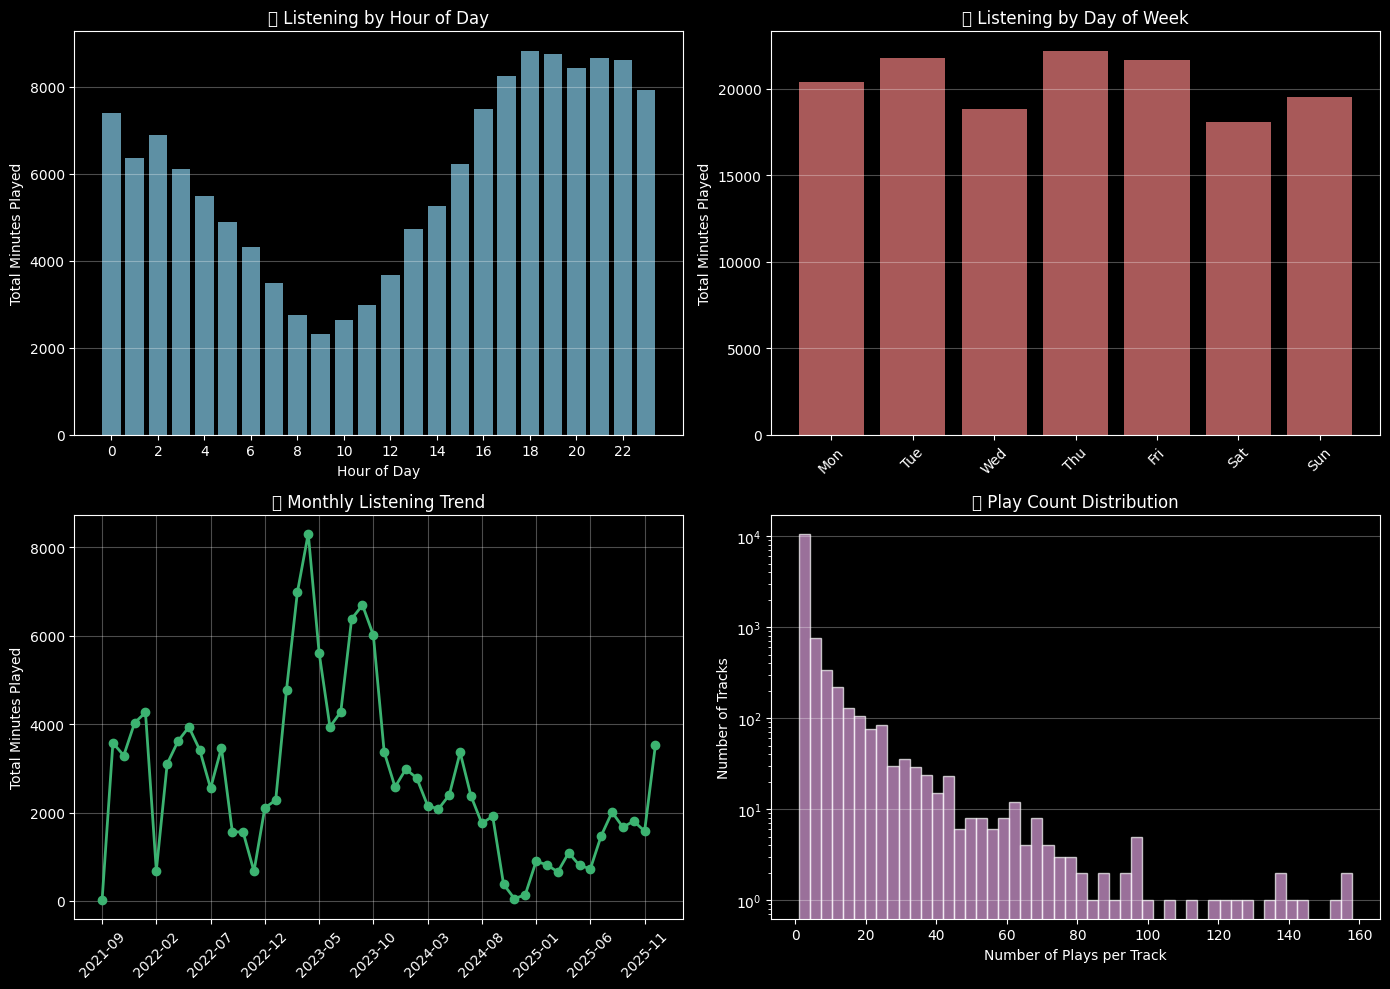


📊 Listening Statistics:
   • Peak listening hour: 18:00 (147.3 hours)
   • Most active day: Thursday
   • Average minutes per day: 111.0
   • Unique tracks played: 12,639


In [11]:
if history is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Hour of day
    hourly = history.groupby('hour')['minutes_played'].sum()
    axes[0, 0].bar(hourly.index, hourly.values, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Total Minutes Played')
    axes[0, 0].set_title('📊 Listening by Hour of Day')
    axes[0, 0].set_xticks(range(0, 24, 2))
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily = history.groupby('day_of_week')['minutes_played'].sum().reindex(day_order)
    axes[0, 1].bar(range(len(daily)), daily.values, alpha=0.7, color='lightcoral')
    axes[0, 1].set_xticks(range(len(daily)))
    axes[0, 1].set_xticklabels([d[:3] for d in daily.index], rotation=45)
    axes[0, 1].set_ylabel('Total Minutes Played')
    axes[0, 1].set_title('📅 Listening by Day of Week')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Monthly trend
    monthly = history.groupby('month')['minutes_played'].sum()
    axes[1, 0].plot(range(len(monthly)), monthly.values, marker='o', linewidth=2, markersize=6, color='mediumseagreen')
    axes[1, 0].set_xticks(range(0, len(monthly), max(1, len(monthly)//10)))
    axes[1, 0].set_xticklabels([str(m) for m in monthly.index[::max(1, len(monthly)//10)]], rotation=45)
    axes[1, 0].set_ylabel('Total Minutes Played')
    axes[1, 0].set_title('📈 Monthly Listening Trend')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Play count distribution
    track_plays = history.groupby([artist_col, track_col]).size()
    axes[1, 1].hist(track_plays.values, bins=50, edgecolor='white', alpha=0.7, color='plum')
    axes[1, 1].set_xlabel('Number of Plays per Track')
    axes[1, 1].set_ylabel('Number of Tracks')
    axes[1, 1].set_title('🎵 Play Count Distribution')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Listening Statistics:")
    print(f"   • Peak listening hour: {hourly.idxmax()}:00 ({hourly.max()/60:.1f} hours)")
    print(f"   • Most active day: {daily.idxmax()}")
    print(f"   • Average minutes per day: {history.groupby('date')['minutes_played'].sum().mean():.1f}")
    print(f"   • Unique tracks played: {history.groupby([artist_col, track_col]).ngroups:,}")


## 8️⃣ Search Queries Analysis

Analyze your search patterns to understand how you discover music.


In [ ]:
# Load search queries
from spotim8.streaming_history import load_search_queries_cached

search_df = load_search_queries_cached(DATA_DIR)

if search_df is not None and len(search_df) > 0:
    print("="*60)
    print("🔍 SEARCH QUERIES ANALYSIS")
    print("="*60)
    
    print(f"\n📊 Total searches: {len(search_df):,}")
    print(f"   Date range: {search_df['timestamp'].min()} to {search_df['timestamp'].max()}")
    
    # Most common searches
    if 'searchQuery' in search_df.columns:
        print("\n🔎 TOP SEARCH QUERIES:")
        top_searches = search_df['searchQuery'].value_counts().head(20)
        for i, (query, count) in enumerate(top_searches.items(), 1):
            print(f"   {i:2}. {query[:50]:50} ({count} searches)")
    
    # Search patterns over time
    if 'month' in search_df.columns:
        print("\n📈 SEARCH ACTIVITY BY MONTH:")
        monthly_searches = search_df.groupby('month').size().sort_index()
        for month, count in monthly_searches.tail(6).items():
            print(f"   {month}: {count} searches")
    
    # Platform distribution
    if 'platform' in search_df.columns:
        print("\n📱 SEARCHES BY PLATFORM:")
        platform_counts = search_df['platform'].value_counts()
        for platform, count in platform_counts.items():
            pct = count / len(search_df) * 100
            print(f"   {platform:20} {count:>5} ({pct:>5.1f}%)")
    
    # Search interaction analysis
    if 'searchInteractionURIs' in search_df.columns:
        print("\n🎵 SEARCH INTERACTIONS:")
        searches_with_results = search_df[search_df['searchInteractionURIs'].notna() & (search_df['searchInteractionURIs'].astype(str) != '[]')]
        print(f"   Searches with results: {len(searches_with_results):,} ({len(searches_with_results)/len(search_df)*100:.1f}%)")
        print(f"   Searches without results: {len(search_df) - len(searches_with_results):,}")
else:
    print("⚠️  No search queries data available")
    print("   Run 01_sync_data.ipynb to sync export data")


## 9️⃣ Wrapped Data Analysis

Analyze your Spotify Wrapped summary data.


In [ ]:
# Load Wrapped data
from spotim8.streaming_history import load_wrapped_data_cached

wrapped_data = load_wrapped_data_cached(DATA_DIR)

if wrapped_data is not None:
    print("="*60)
    print("🎁 SPOTIFY WRAPPED ANALYSIS")
    print("="*60)
    
    # Top artists
    if 'topArtists' in wrapped_data:
        artists = wrapped_data['topArtists']
        print(f"\n🎤 TOP ARTISTS:")
        print(f"   Unique artists: {artists.get('numUniqueArtists', 'N/A')}")
        print(f"   Top artist listening time: {artists.get('topArtistMilliseconds', 0) / 60000:.0f} minutes")
        print(f"   Fan percentage: {artists.get('topArtistFanPercentage', 0) * 100:.3f}%")
        
        if 'topArtists' in artists:
            print("\n   Top 5 Artists:")
            for i, artist in enumerate(artists['topArtists'][:5], 1):
                uri = artist.get('artistUri', '')
                artist_id = uri.replace('spotify:artist:', '') if uri else 'N/A'
                print(f"      {i}. {artist_id}")
    
    # Top tracks
    if 'topTracks' in wrapped_data:
        tracks = wrapped_data['topTracks']
        print(f"\n🎵 TOP TRACKS:")
        print(f"   Distinct tracks played: {tracks.get('distinctTracksPlayed', 'N/A')}")
        print(f"   Top track play count: {tracks.get('topTrackPlayCount', 'N/A')}")
        print(f"   First play date: {tracks.get('topTrackFirstPlayedDate', 'N/A')}")
        
        if 'topTracks' in tracks:
            print("\n   Top 5 Tracks:")
            for i, track_uri in enumerate(tracks['topTracks'][:5], 1):
                track_id = track_uri.replace('spotify:track:', '') if track_uri else 'N/A'
                print(f"      {i}. {track_id}")
    
    # Yearly metrics
    if 'yearlyMetrics' in wrapped_data:
        metrics = wrapped_data['yearlyMetrics']
        print(f"\n📊 YEARLY METRICS:")
        total_minutes = metrics.get('totalMsListened', 0) / 60000
        print(f"   Total listening time: {total_minutes:,.0f} minutes ({total_minutes/60:.1f} hours)")
        print(f"   Most listened day: {metrics.get('mostListenedDay', 'N/A')}")
        print(f"   Most listened day minutes: {metrics.get('mostListenedDayMinutes', 0):.0f}")
        print(f"   Percentile vs worldwide: {metrics.get('percentGreaterThanWorldwideUsers', 0):.1f}%")
    
    # Music evolution
    if 'musicEvolution' in wrapped_data:
        evolution = wrapped_data['musicEvolution']
        if 'eras' in evolution:
            print(f"\n🎸 MUSIC EVOLUTION:")
            for era in evolution['eras'][:5]:
                print(f"   • {era.get('genre', 'N/A')} - {era.get('mood', 'N/A')} ({era.get('descriptor', 'N/A')})")
else:
    print("⚠️  No Wrapped data available")
    print("   Run 01_sync_data.ipynb to sync export data")


## 🔟 Playback Errors & Technical Analysis

Analyze playback errors and technical issues to understand playback reliability.


In [ ]:
# Load playback errors and retries
from spotim8.streaming_history import load_playback_errors_cached, load_playback_retries_cached, load_webapi_events_cached

errors_df = load_playback_errors_cached(DATA_DIR)
retries_df = load_playback_retries_cached(DATA_DIR)
webapi_df = load_webapi_events_cached(DATA_DIR)

if errors_df is not None and len(errors_df) > 0:
    print("="*60)
    print("⚠️  PLAYBACK ERRORS ANALYSIS")
    print("="*60)
    
    print(f"\n📊 Total errors: {len(errors_df):,}")
    if 'timestamp' in errors_df.columns:
        print(f"   Date range: {errors_df['timestamp'].min()} to {errors_df['timestamp'].max()}")
    
    # Error types
    if 'message_reason' in errors_df.columns:
        print("\n🔍 ERROR REASONS:")
        error_reasons = errors_df['message_reason'].value_counts().head(10)
        for reason, count in error_reasons.items():
            print(f"   • {reason}: {count} errors")
    
    # Errors by device
    if 'context_device_type' in errors_df.columns:
        print("\n📱 ERRORS BY DEVICE:")
        device_errors = errors_df['context_device_type'].value_counts()
        for device, count in device_errors.items():
            print(f"   • {device}: {count} errors")
    
    # Errors over time
    if 'month' in errors_df.columns:
        print("\n📈 ERRORS BY MONTH:")
        monthly_errors = errors_df.groupby('month').size().sort_index().tail(6)
        for month, count in monthly_errors.items():
            print(f"   {month}: {count} errors")
else:
    print("ℹ️  No playback errors found (good!)")

if retries_df is not None and len(retries_df) > 0:
    print(f"\n🔄 PLAYBACK RETRIES: {len(retries_df):,} retry attempts")
    if 'message_status' in retries_df.columns:
        retry_status = retries_df['message_status'].value_counts()
        print("   Retry outcomes:")
        for status, count in retry_status.items():
            print(f"      • {status}: {count}")
else:
    print("\nℹ️  No playback retries found")

if webapi_df is not None and len(webapi_df) > 0:
    print(f"\n🌐 WEB API EVENTS: {len(webapi_df):,} events")
    if 'message_status_code' in webapi_df.columns:
        status_codes = webapi_df['message_status_code'].value_counts().head(10)
        print("   Status codes:")
        for code, count in status_codes.items():
            print(f"      • {code}: {count} events")
else:
    print("\nℹ️  No Web API events found")


## 1️⃣1️⃣ Follow & Social Analysis

Analyze your follow relationships and social connections.


In [ ]:
# Load follow data
from spotim8.streaming_history import load_follow_data_cached

follow_df = load_follow_data_cached(DATA_DIR)

if follow_df is not None and len(follow_df) > 0:
    print("="*60)
    print("👥 FOLLOW RELATIONSHIPS")
    print("="*60)
    
    # Count by relationship type
    if 'relationship' in follow_df.columns:
        print("\n📊 RELATIONSHIP SUMMARY:")
        relationship_counts = follow_df['relationship'].value_counts()
        for rel, count in relationship_counts.items():
            print(f"   • {rel}: {count} users")
    
    # Show some examples
    print("\n👤 SAMPLE RELATIONSHIPS:")
    for rel_type in follow_df['relationship'].unique()[:3]:
        sample = follow_df[follow_df['relationship'] == rel_type]['user'].head(5)
        print(f"\n   {rel_type.upper()}:")
        for user in sample:
            print(f"      • {user}")
    
    # Mutual follows
    if 'relationship' in follow_df.columns:
        following = set(follow_df[follow_df['relationship'] == 'following']['user'])
        followed_by = set(follow_df[follow_df['relationship'] == 'followed_by']['user'])
        mutual = following & followed_by
        if mutual:
            print(f"\n🤝 MUTUAL FOLLOWS: {len(mutual)} users")
            for user in list(mutual)[:10]:
                print(f"   • {user}")
else:
    print("⚠️  No follow data available")
    print("   Run 01_sync_data.ipynb to sync export data")


## 9️⃣ Summary & Next Steps

### 📋 Key Findings & Recommendations


In [12]:
print("="*70)
print("SUMMARY & RECOMMENDATIONS")
print("="*70)

print("""
🎯 WHAT THIS DATA ADDS TO SPOTIM8:

1. 📊 ACTUAL LISTENING BEHAVIOR
   • Current: Only knows what's in playlists/library
   • New: Shows what you actually listen to
   • Value: Identify true favorites vs. saved but never played tracks

2. ⏰ TEMPORAL PATTERNS
   • Current: Static library snapshots
   • New: Listening trends over time, time-of-day patterns
   • Value: Understand listening habits, create time-based playlists

3. 🔍 DISCOVERY PATTERNS
   • Current: No search/discovery data
   • New: Search queries, discovery paths
   • Value: Understand how you find new music, improve recommendations

4. 🎵 PLAY COUNT & FREQUENCY
   • Current: Playlist membership only
   • New: Actual play counts, repeat listening patterns
   • Value: Create "Most Played" playlists, identify comfort tracks

5. 📱 PLATFORM & DEVICE INSIGHTS
   • Current: No device/platform data
   • New: Where/how you listen (mobile, desktop, offline)
   • Value: Optimize sync/playback for your usage patterns

6. ⚠️ TECHNICAL HEALTH
   • Current: No error/performance data
   • New: Playback errors, retries, connection issues
   • Value: Identify problematic tracks/devices, improve reliability

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 RECOMMENDED ENHANCEMENTS FOR PLAYLIST AUTOMATION:

1. ✅ Create "Most Played" monthly playlists from actual listening data
   → Add to scripts/sync.py alongside existing monthly playlists
   → Playlists like "AJTopDec25" (top 25 most played in December)

2. ✅ Generate time-based playlists (morning, evening, weekend)
   → Analyze listening patterns by hour/day
   → Auto-create playlists that match your routine

3. ✅ "Discovery Playlist" - tracks you searched for but didn't save
   → Cross-reference search queries with listening history
   → Help you remember tracks you wanted to check out

4. ✅ "Comfort Zone" playlist - most repeated tracks
   → Identify tracks with high play frequency
   → Update monthly with new repeat tracks

5. ✅ "Forgotten Favorites" - tracks in library but not played recently
   → Compare library with listening history
   → Suggest cleanup or re-discovery

6. ✅ Skip rate analysis to improve playlist quality
   → Use extended history skip data
   → Remove frequently skipped tracks from auto-generated playlists

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 RECOMMENDED ENHANCEMENTS FOR REDUNDANT PLAYLIST FINDER:

1. ✅ Listening-based similarity (beyond track overlap)
   → Compare playlists by shared listening patterns
   → Find functionally redundant playlists even with low track overlap

2. ✅ Playlist usage analysis
   → Identify playlists where <10% of tracks have been played
   → Mark as candidates for deletion/consolidation

3. ✅ Temporal redundancy detection
   → Group playlists by when tracks are typically played
   → Suggest merging playlists with similar temporal usage

4. ✅ Weighted redundancy scores
   → Weight similarity by actual listening frequency
   → Focus on playlists you actually use

5. ✅ Smart consolidation suggestions
   → Consider both track overlap AND listening patterns
   → More intelligent merge recommendations

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📈 IMPLEMENTATION PRIORITY:

HIGH PRIORITY (Easy wins, high value):
1. Most Played monthly playlists (add to sync.py)
2. Playlist usage analysis (add to redundant playlist finder)
3. Listening vs library comparison (new analysis feature)

MEDIUM PRIORITY (Moderate effort, good value):
4. Time-based playlist generation
5. Discovery playlist generation
6. Enhanced redundancy detection with listening weights

LOW PRIORITY (Complex, nice to have):
7. Skip rate analysis for playlist improvement
8. Temporal redundancy detection
9. Technical log analysis for playback optimization

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🚀 NEXT STEPS:

1. Review this analysis to understand your listening patterns
2. Choose which enhancements to implement first
3. Start with high-priority items (most played playlists, usage analysis)
4. Test enhancements in development before deploying to production
5. Consider creating a new module: spotim8/listening.py for listening analysis
""")


SUMMARY & RECOMMENDATIONS

🎯 WHAT THIS DATA ADDS TO SPOTIM8:

1. 📊 ACTUAL LISTENING BEHAVIOR
   • Current: Only knows what's in playlists/library
   • New: Shows what you actually listen to
   • Value: Identify true favorites vs. saved but never played tracks

2. ⏰ TEMPORAL PATTERNS
   • Current: Static library snapshots
   • New: Listening trends over time, time-of-day patterns
   • Value: Understand listening habits, create time-based playlists

3. 🔍 DISCOVERY PATTERNS
   • Current: No search/discovery data
   • New: Search queries, discovery paths
   • Value: Understand how you find new music, improve recommendations

4. 🎵 PLAY COUNT & FREQUENCY
   • Current: Playlist membership only
   • New: Actual play counts, repeat listening patterns
   • Value: Create "Most Played" playlists, identify comfort tracks

5. 📱 PLATFORM & DEVICE INSIGHTS
   • Current: No device/platform data
   • New: Where/how you listen (mobile, desktop, offline)
   • Value: Optimize sync/playback for your usage p